In [2]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

In [3]:
# phi_t(x) = sqrt(alpha) pi^(-1/4) exp(-alpha^2 x^2 / 2)
def HarmonicOscillator(alpha):
    class Oscillator(object):
        @staticmethod
        def local_energy(pos):
            term = alpha**2 + (1 - alpha**4) * pos.dot(pos)
            return term/2
        
        @staticmethod
        def wavefunction(pos):
            return np.sqrt(alpha) * np.exp(-alpha**2 * pos.dot(pos)/2)
    return Oscillator

In [4]:
class VMC(object):
    def __init__(self, nwalkers, dimension):
        self.walkers = np.random.random((nwalkers, dimension))
    
    def step(self, dt):
        energy = 0.0
        for walker_i, walker in enumerate(self.walkers):
            phi_before = self.wavefunction(walker)
            energy_before = self.local_energy(walker)
            
            proposal = walker + np.random.normal() * dt
            phi_after = self.wavefunction(proposal)
            energy_after = self.local_energy(proposal)
            
            acceptance_probability = (phi_after/phi_before)**2
            if acceptance_probability > np.random.random():
                walker[:] = proposal
                
            energy += acceptance_probability*energy_after + (1-acceptance_probability)*energy_before
        return energy/len(self.walkers)

In [ ]:
alphas = np.linspace(0.3,1.3,15)
energies = []
variances = []
for alpha in alphas:
    class SHO_VMC(VMC, HarmonicOscillator(alpha)): pass
    vv = SHO_VMC(500, 1)
    [vv.step(0.3) for ii in xrange(200)] # equilibrate
    energy_samples = [vv.step(0.3) for ii in xrange(500)]
    energies.append(np.mean(energy_samples))
    variances.append(np.std(energy_samples))
    print ".",

In [ ]:
plt.plot(alphas,energies)

In [ ]:
plt.plot(alphas, variances)

### Reweighting

After an equilibration run at a given set of parameters $\vec a$, we have a set of configurations distributed according to the (square of the) trial wavefunction, at those parameter values.

We would like to compute the average energy and its variance at some new set of parameters $\vec a'$.

To do so, we need to reweight each configuration $\vec x$ by multiplying any observable at that configuration by $\frac{\phi_{a'}(\vec x)^2}{\phi_{a}(\vec x)^2}$.

Suppose we had $N$ samples at the original set of parameters. Then, after reweighting, the effective number of samples at the new set of parameters is given by

$$\frac{N_{eff}}{N} = \frac{\langle w \rangle^2}{\langle w^2 \rangle}$$

where $w(\vec x) = \frac{\phi_{a'}(\vec x)^2}{\phi_{a}(\vec x)^2}$

In [5]:
def reweight_samples(wavefunction_before, wavefunction_after, samples):
    weights = []
    for sample in samples:
        phi_before = wavefunction_before(sample)
        phi_after  = wavefunction_after(sample)
        weight = (phi_after/phi_before)**2
        weights.append(weight)
    weights = np.array(weights)
    def n_effective():
        return len(samples)*np.mean(weights)**2/np.mean(weights**2)
    return weights, n_effective()

Let's try it out: first, generate 500 samples at $\alpha=0.8$:

In [48]:
class SHO_VMC(VMC, HarmonicOscillator(0.8)): pass
vv = SHO_VMC(500,1)
for ii in xrange(200): 
    vv.step(0.3)

Next, reweight these samples to different $\alpha$'s. 

At each $\alpha$, we compute the local energies of the old samples with new weights. From these, we can compute the mean and variance of the energy observable.

In [60]:
def reweighted_energies(weights, local_energy_after, samples):
    energies = []
    for sample in samples:
        energies.append(local_energy_after(sample))
    energies = np.array(energies)
    new_energies = len(energies)*energies*weights/np.sum(weights)
    return new_energies
    
alphas = np.linspace(0.3,5.7,55)
energy_means, energy_variances, n_effs = [],[],[]
for alpha in alphas:
    sho_after = HarmonicOscillator(alpha)
    weights, n_eff = reweight_samples(SHO_VMC.wavefunction, sho_after.wavefunction, vv.walkers)
    new_energies = reweighted_energies(weights, sho_after.local_energy, vv.walkers)
    energy_means.append(np.mean(new_energies))
    energy_variances.append(np.std(new_energies)**2)
    n_effs.append(n_eff)

Because of the variational principle and the fact that $\alpha=1$ is the exact solution for this system, we see that the energy has a minimum and the variance drops to 0 at $\alpha=1$. 

But because the samples are originally from $\alpha=0.8$, we see that $N_{eff}$ has its maximum at that value.

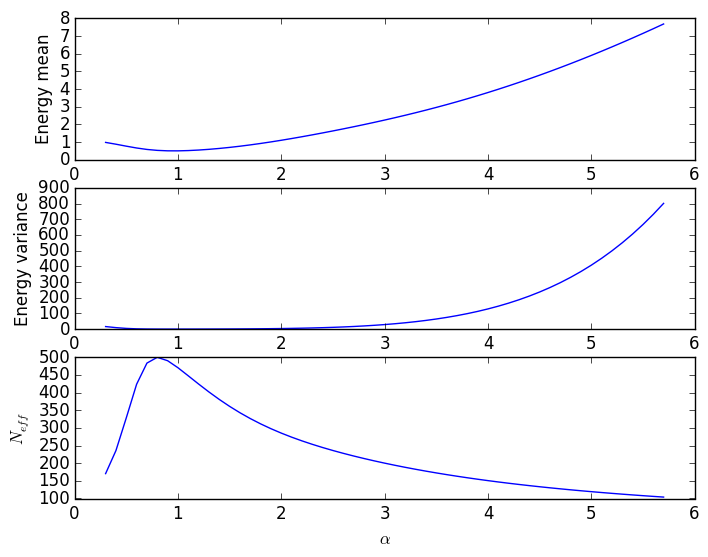

In [61]:
plt.subplot(311)
plt.plot(alphas, energy_means, label="energies")
plt.ylabel("Energy mean")
plt.subplot(312)
plt.plot(alphas, energy_variances)
plt.ylabel("Energy variance")
plt.subplot(313)
plt.plot(alphas, n_effs)
plt.ylabel("$N_{eff}$")
plt.xlabel("$\\alpha$")

### Wavefunction optimization

This idea of reweighting samples can be used to turn a stochastic optimization problem into a deterministic one. We want to find the set of parameters $\vec a$ that minimize either the energy or the variance of the energy.

To do so, we generate samples at some initial set of parameters $\vec a'$. Now, holding these samples fixed, we solve the problem of minimizing the energy of just these samples, after reweighting.

Thus, instead of generating new samples at each set of parameters $\vec a$, we simply reweight the old samples, which is a smooth and deterministic problem.

Having found the optimal $\vec a$ for that set of samples, we generate a fresh set of samples at the new $\vec a$ and optimize again, until we find a fixed-point of the process.

In [66]:
def optimize_wavefunction(WavefunctionFactory, parameters_initial, n_samples=500, dimension=1):
    wf_before = WavefunctionFactory(parameters_initial)
    class WF_VMC(VMC, wf_before): pass
    sampler = WF_VMC(n_samples,dimension)
    for ii in xrange(300):
        sampler.step(0.3)
    
    def objective_function(alpha):
        wf_after = WavefunctionFactory(float(alpha))
        weights, n_eff = reweight_samples(wf_before.wavefunction, wf_after.wavefunction, sampler.walkers)
        new_energies = reweighted_energies(weights, wf_after.local_energy, sampler.walkers)
        return new_energies - np.mean(new_energies)
    
    from scipy.optimize import leastsq
    return leastsq(objective_function, parameters_initial)

In [68]:
optimize_wavefunction(HarmonicOscillator, 0.3)

(array([ 0.70427414]), 1)

In [69]:
optimize_wavefunction(HarmonicOscillator, 0.70427414)

(array([ 0.88458726]), 1)

In [70]:
optimize_wavefunction(HarmonicOscillator, 0.88458726)

(array([ 0.95872417]), 1)

In [71]:
optimize_wavefunction(HarmonicOscillator, 0.95872417)

(array([ 0.9859624]), 3)

In [72]:
optimize_wavefunction(HarmonicOscillator, 0.9859624)

(array([ 0.99526321]), 3)

In [73]:
optimize_wavefunction(HarmonicOscillator, 0.99526321)

(array([ 0.99841669]), 2)

In [74]:
optimize_wavefunction(HarmonicOscillator, 0.99841669)

(array([ 0.9994719]), 3)

In [75]:
optimize_wavefunction(HarmonicOscillator, 0.9994719)

(array([ 0.9998239]), 2)